# Importálás

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
# Nlp library
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
from sklearn.feature_extraction.text import CountVectorizer

# sklearn Library
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import explained_variance_score

#Tenserflow Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding,  Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

C:\Users\kvend\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Adatvizualizáció

In [2]:
jobs = pd.read_csv('fake_job_postings.csv')

In [3]:
jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<AxesSubplot:ylabel='fraudulent'>

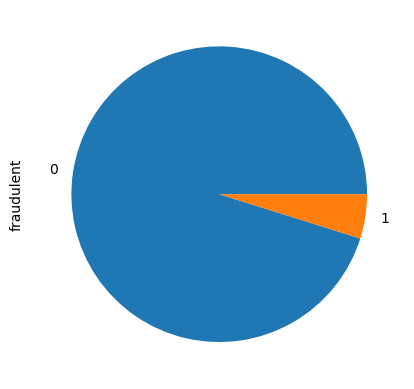

In [4]:
jobs.fraudulent.value_counts().plot(kind='pie')

In [5]:
print(jobs.fraudulent.value_counts()[0]/len(jobs))
print(jobs.fraudulent.value_counts()[0])
print(jobs.fraudulent.value_counts()[1])

0.9515659955257271
17014
866


In [6]:
def isNaN(string):
    return string != string

In [7]:
y0=[]
y1=[]
for c in jobs.columns:
    y0.append(len(jobs[c][isNaN(jobs[c])==1][jobs.fraudulent==0])/jobs.fraudulent.value_counts()[0])
    y1.append(len(jobs[c][isNaN(jobs[c])==1][jobs.fraudulent==1])/jobs.fraudulent.value_counts()[1])

Text(0.5, 1.0, 'NaN ratio')

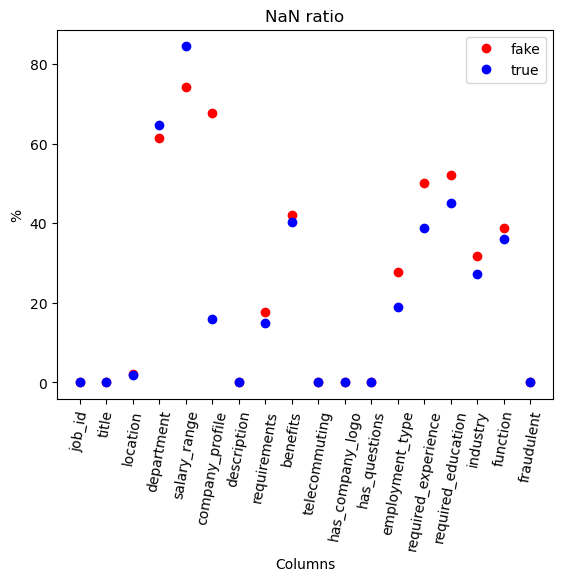

In [8]:
import matplotlib.pyplot as plt
x=jobs.columns
plt.plot(x,100*np.array(y1),'ro',x,100*np.array(y0),'bo')
plt.legend(["fake", "true"])
plt.ylabel('%')
plt.xlabel('Columns')
plt.xticks(rotation=80)
plt.title("NaN ratio")

In [9]:
jobs.title = jobs.title.str.strip()
title = jobs.title.value_counts()[:10]

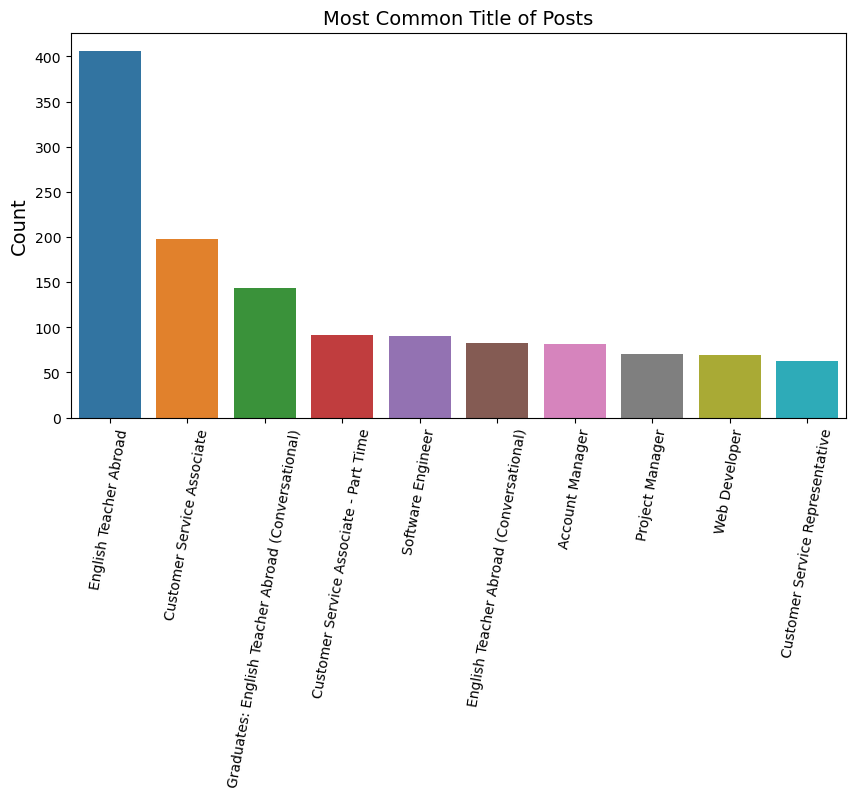

In [10]:
plt.figure(figsize = (10,5))
sb.barplot(x = title.index, y = title )
plt.title("Most Common Title of Posts", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=80);

In [11]:
location = jobs.location.value_counts()[:10]

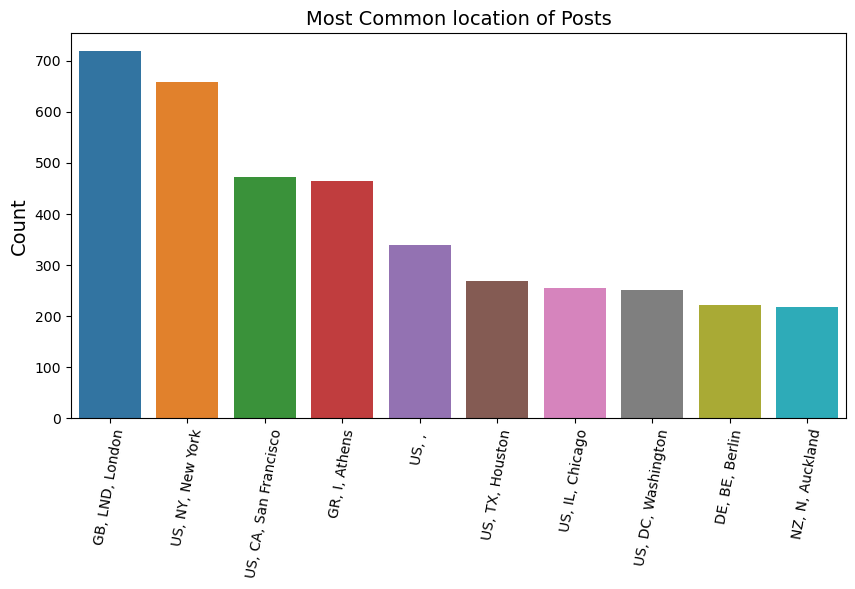

In [12]:
plt.figure(figsize = (10,5))
sb.barplot(x = location.index, y = location )
plt.title("Most Common location of Posts", fontdict = {"fontsize" : 14})
plt.ylabel("Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=80);

In [13]:
loc=jobs.location.value_counts(dropna=False)
loc1=jobs.location[jobs.fraudulent==1].value_counts(dropna=False)
ratio=loc1.divide(loc, fill_value=0)
y=[]
for r in ratio.values:
    y.append(len(ratio[ratio==r]))

Text(0.5, 1.0, 'Number of location with the fake probability')

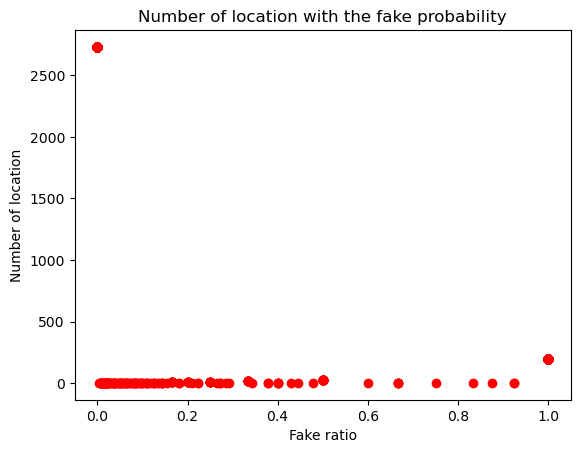

In [14]:
plt.plot(ratio.values,y,'ro')
plt.ylabel('Number of location')
plt.xlabel('Fake ratio')
plt.title("Number of location with the fake probability")

# Naive Bayes

In [15]:
is_fraud = jobs['fraudulent'] == 1
df_try = jobs[is_fraud]
jobs_over=jobs
jobs_over=jobs_over.append([df_try]*18,ignore_index=True)

<AxesSubplot:ylabel='fraudulent'>

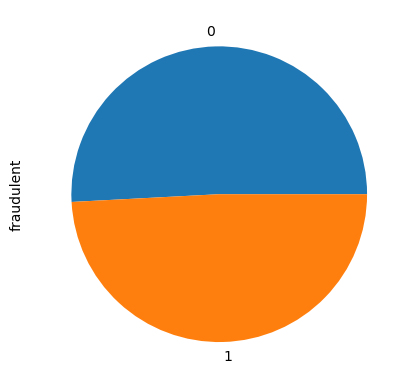

In [16]:
jobs_over.fraudulent.value_counts().plot(kind='pie')

In [17]:
from sklearn import preprocessing
jobs_last = jobs_over.drop(columns = ['job_id','company_profile', 'description', 'benefits', 'requirements','fraudulent'])
jobs_last.head()
X=np.zeros((len(jobs_last),len(jobs_last.columns)))
for j in range(len(jobs_last.columns)):
    le = preprocessing.LabelEncoder()
    # Converting string labels into numbers.
    Xoszlop=le.fit_transform(jobs_last[jobs_last.columns[j]])
    X[:,j]=Xoszlop
print(X[0])

[5.811e+03 2.535e+03 7.580e+02 8.740e+02 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 4.000e+00 1.300e+01 1.310e+02 2.200e+01]


In [18]:
y = jobs_over.fraudulent.values
y = y.reshape(-1,1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 0)

In [20]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB(class_prior=[jobs_over.fraudulent.value_counts()[0],jobs_over.fraudulent.value_counts()[1]])
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [21]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9521959964146998


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred,y_test)

array([[1516,   21],
       [ 139, 1671]], dtype=int64)

# Adat átalakítás numerikus értékekké

In [23]:
jobs_last = jobs_over.drop(columns = ['job_id','department',
                             'salary_range', 'company_profile','description','requirements','benefits','fraudulent'])
jobs_last.head()

,title,location,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,Marketing Intern,"US, NY, New York",0,1,0,Other,Internship,NaN,NaN,Marketing
1,Customer Service - Cloud Video Production,"NZ, , Auckland",0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",0,1,0,NaN,NaN,NaN,NaN,NaN
3,Account Executive - Washington DC,"US, DC, Washington",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,Bill Review Manager,"US, FL, Fort Worth",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider


In [24]:
from sklearn.preprocessing import OneHotEncoder
# Minden oszlopot elkódolok a onehot kódolással
onehot=dict()
for c in jobs_last.columns:
    X=jobs_last[c].array.reshape(-1,1)
    enc = OneHotEncoder(handle_unknown='ignore')
    onehot[c]=enc.fit_transform(X).toarray()

In [25]:
import random
X=[]
rand=[]
for i in range(5000): # Kiválsztok 5000 véletlen sort.
    rand.append(random.randint(0, 33467))

for i in range(5000): # Ezekhez a sorokhoz összefűzöm az oszlopoknak megfelelő 0-1 vektorokat. 
    Xi=[]
    for c in jobs_last.columns:
        Xi=Xi+list(onehot[c][rand[i]])
    X.append(Xi)

In [26]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X=pca.fit_transform(X)
print(pca.get_params())
print(X)

{'copy': True, 'iterated_power': 'auto', 'n_components': 100, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}
[[-0.89466762 -0.76879659 -0.16185776 ... -0.03161016  0.02120328
  -0.0309582 ]
 [ 0.90352082 -0.6440501   0.02954918 ...  0.02661677 -0.01488371
   0.06886112]
 [ 1.5628146  -0.14572906 -0.02385925 ... -0.02997077 -0.02222346
  -0.04337377]
 ...
 [-0.88604308 -0.87593244 -0.05647677 ... -0.01136731 -0.06441597
   0.0636636 ]
 [-0.33799037 -1.49007642  0.58993255 ... -0.01902189 -0.00463343
   0.01861317]
 [-1.1560746  -0.26372234 -0.97258519 ...  0.01238954  0.00542711
   0.00431821]]


In [27]:
# A fraudulent értékek
y=np.zeros(5000)
for i in range(5000):
    y[i]=jobs_over.fraudulent[rand[i]]
y = y.reshape(-1,1)
print(y)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


# Support Vector Machine

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 101)

In [29]:
from sklearn import svm
clf = svm.SVC(kernel='poly',max_iter=1000)
clf = clf.fit(X_train, y_train)

In [30]:
y_pred = clf.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred,y_test)

array([[227,  22],
       [ 17, 234]], dtype=int64)

# Decision Tree

In [32]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=10)
clf = clf.fit(X_train, y_train)

In [33]:
#tree.plot_tree(clf)

In [34]:
y_pred = clf.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred,y_test)

array([[222,  14],
       [ 22, 242]], dtype=int64)

# Random forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf = clf.fit(X_train, y_train)

In [37]:
y_pred = clf.predict(X_test)

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred,y_test)

array([[237,   9],
       [  7, 247]], dtype=int64)

# Neural network

In [39]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
mlp = MLPClassifier(solver = 'lbfgs', activation = 'relu',
                   hidden_layer_sizes = (100,50,30), 
                    max_iter = 1000)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

#Printing out our evaluation metrics
print(roc_auc_score(y_test, mlp_pred))
print(classification_report(y_test, mlp_pred))

0.9654521004098361
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       244
         1.0       0.95      0.99      0.97       256

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(mlp_pred,y_test)

array([[230,   3],
       [ 14, 253]], dtype=int64)

# TFIDF

In [41]:
jobs_over.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [60]:
jobs_text = pd.DataFrame()
jobs_text["text"]=jobs_over["company_profile"].fillna('')+jobs_over["description"].fillna('')+jobs_over["requirements"].fillna('')
jobs_text['word count'] = [len(i.split(' ')) for i in jobs_text['text']]
jobs_text["fraudulent"]=jobs_over["fraudulent"]
jobs_text

,text,word count,fraudulent
0,"We're Food52, and we've created a groundbreaki...",378,0
1,"90 Seconds, the worlds Cloud Video Production ...",644,0
2,Valor Services provides Workforce Solutions th...,348,0
3,Our passion for improving quality of life thro...,602,0
4,SpotSource Solutions LLC is a Global Human Cap...,474,0
...,...,...,...
33463,Student Positions Part-Time and Full-Time.You ...,58,1
33464,LEARN TO EARN AN EXECUTIVE LEVEL INCOMEFULL TR...,130,1
33465,inFullMobile Sp. z o.o. is a mobile software d...,220,1
33466,JOB DESCRIPTIONWe are seeking a full time payr...,74,1


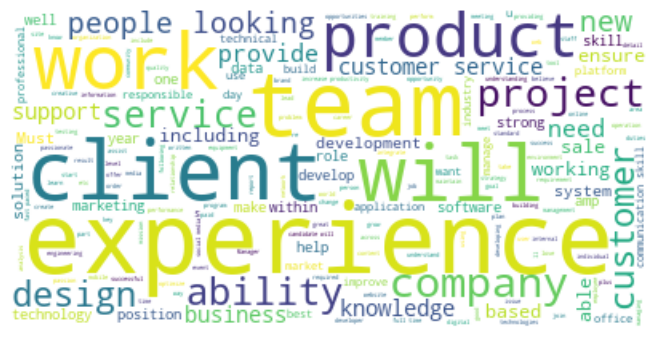

In [51]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in jobs_text['text'][:1000])
wordcloud = WordCloud(background_color = "white", max_words = 500).generate(text)
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [52]:
#TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(jobs_text["text"].fillna('').array)

In [53]:
#Dimenziócsökkentés SVD-vel
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X=svd.fit_transform(X)
print(pca.get_params())
print(X)

{'copy': True, 'iterated_power': 'auto', 'n_components': 100, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}
[[ 0.38026479 -0.07277247  0.01516422 ... -0.00203652  0.01415998
   0.00282382]
 [ 0.32012242 -0.02725698  0.01243806 ...  0.03716635  0.01505466
   0.04115314]
 [ 0.3988185  -0.0506973   0.01953327 ... -0.09360264 -0.03854571
  -0.01372828]
 ...
 [ 0.38044883  0.0106567  -0.00324136 ... -0.00888217  0.04061287
  -0.0052506 ]
 [ 0.19587205  0.00801619  0.00332825 ...  0.08487309 -0.03175259
  -0.09349555]
 [ 0.26906803  0.00869062 -0.00840909 ...  0.0021492   0.01147107
   0.02450932]]


In [54]:
y=jobs_text["fraudulent"].array.reshape(-1,1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 101)

In [56]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
mlp = MLPClassifier(solver = 'lbfgs', activation = 'relu',
                   hidden_layer_sizes = (100,50,30), 
                    max_iter = 1000)

mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

#Printing out our evaluation metrics
print(roc_auc_score(y_test, mlp_pred))
print(classification_report(y_test, mlp_pred))

0.9961629279811097
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1694
           1       0.99      1.00      1.00      1653

    accuracy                           1.00      3347
   macro avg       1.00      1.00      1.00      3347
weighted avg       1.00      1.00      1.00      3347



In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix(mlp_pred,y_test)

array([[1681,    0],
       [  13, 1653]], dtype=int64)

# Eddig van

Az ezután levőben csak lemásoltam egy kódot (https://www.kaggle.com/code/mesutbilgin/real-fake-job-posting-prediciton-bidirtnl-lstm). De valamiért ez nem ad jó eredményt.

In [77]:
sent_length=jobs_text['word count'].max()
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(10000,embedding_vector_features,input_length=100))
model1.add(Bidirectional(LSTM(20 )))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 40)           400000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 409,801
Trainable params: 409,801
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [73]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [74]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

cp = ModelCheckpoint("./bidirectional_model/" ,save_best_only = True)## creaitng model checkpoint
hist = model1.fit(X_train, y_train, epochs = 5, batch_size = 64,  callbacks = cp, validation_data=(X_test,y_test))

Epoch 1/5
471/471 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5029

INFO:tensorflow:Assets written to: ./bidirectional_model\assets


INFO:tensorflow:Assets written to: ./bidirectional_model\assets


471/471 [==============================] - 69s 136ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.4939
Epoch 2/5
471/471 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5072

INFO:tensorflow:Assets written to: ./bidirectional_model\assets


INFO:tensorflow:Assets written to: ./bidirectional_model\assets


471/471 [==============================] - 66s 141ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6931 - val_accuracy: 0.5061
Epoch 3/5
471/471 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5080

INFO:tensorflow:Assets written to: ./bidirectional_model\assets


INFO:tensorflow:Assets written to: ./bidirectional_model\assets


471/471 [==============================] - 74s 156ms/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6931 - val_accuracy: 0.5061
Epoch 4/5
471/471 [==============================] - 46s 98ms/step - loss: 0.6931 - accuracy: 0.5065 - val_loss: 0.6932 - val_accuracy: 0.5061
Epoch 5/5
471/471 [==============================] - 44s 94ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6932 - val_accuracy: 0.5061


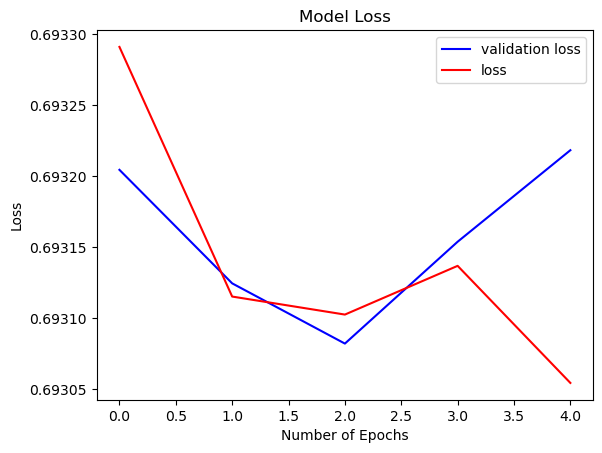

In [75]:
plt.plot(hist.history['val_loss'], color='b', label="validation loss")
plt.plot(hist.history['loss'], color='red', label="loss")
plt.title("Model Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

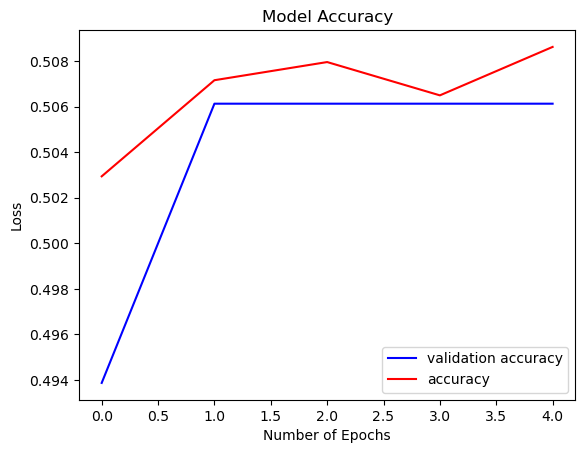

In [76]:
plt.plot(hist.history['val_accuracy'], color='b', label="validation accuracy")
plt.plot(hist.history['accuracy'], color='red', label="accuracy")
plt.title("Model Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Adat átalakítás

Csak a description oszlopot tartom meg.

In [ ]:
jobs_last = jobs.drop(columns = ['job_id','title','location','department', 'telecommuting',
                             'salary_range','company_profile','requirements','benefits','employment_type',
                             'required_experience','required_education','industry','function','has_company_logo','has_questions'])
jobs_last.head()

In [ ]:
jobs_last.fillna(" ", inplace = True)
jobs_last['word count'] = [len(i.split(' ')) for i in jobs_last['description']]

In [ ]:
jobs_last.head()

Átalakítom a szavak számokká. Minden szó egy sorszámot kap, így minden description egy vektor lesz.

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

In [ ]:
max_features = 10000
t = Tokenizer(num_words = max_features)
# fit the tokenizer on the documents
t.fit_on_texts(list(jobs_last['description']))

In [ ]:
encoded_docs = t.texts_to_sequences(list(jobs_last['description']))

In [ ]:
sent_length = jobs_last['word count'].max()
embedded_docs=pad_sequences(encoded_docs,padding='pre',maxlen=sent_length)

In [ ]:
print(embedded_docs)

In [ ]:
y = jobs_last.fraudulent.values
y = y.reshape(-1,1)
X = np.array(embedded_docs)

# Egyszerű Döntési fa

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 101)

In [ ]:
print("X_train shape: ",X_train.shape)
print("X_test shape : ",X_test.shape )
print("y_train shape: ",y_train.shape)
print("y_test shape : ",y_test.shape)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=10)
clf = clf.fit(X_train, y_train)

In [ ]:
#tree.plot_tree(clf)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
# Az előző kézzel.
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=clf.predict([X_test[i]])
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

In [ ]:
print(acc[1,1]/sum(acc[:,1]))

In [ ]:
depth=np.arange(1,15)
acc1=[]
for j in range(1,15):
    clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=j)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc=np.zeros((2,2))
    for i in range(len(X_test)):
        if y_pred[i]==0 and y_test[i]==0:
            acc[0,0]=acc[0,0]+1
        if y_pred[i]==1 and y_test[i]==0:
            acc[1,0]=acc[1,0]+1
        if y_pred[i]==0 and y_test[i]==1:
            acc[0,1]=acc[0,1]+1
        if y_pred[i]==1 and y_test[i]==1:
            acc[1,1]=acc[1,1]+1
    acc1.append(acc[1,1]/sum(acc[:,1]))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(depth,acc1,'ro')
plt.ylabel('fake news ratio')
plt.xlabel('Tree depth')

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='poly',max_iter=10000)
clf = clf.fit(X_train[:600], y_train[:600])

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
# Az előző kézzel.
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=clf.predict([X_test[i]])
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

In [ ]:
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [ ]:
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=clf.predict([X_test[i]])
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

In [ ]:
>>> from sklearn.feature_extraction.text import TfidfVectorizer
>>> corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]
>>> vectorizer = TfidfVectorizer()
>>> X = vectorizer.fit_transform(corpus)
>>> print(vectorizer.get_feature_names_out())
print(X.toarray())
>>> print(X.shape)
print(type(X))
vectorizer.vocabulary_.get('is')